# UBC Dataset - 20 Random Tiles 512 px 
* Pipeline
    * Create new write folder 
    * grab 20 random tiles of size 512 x 512 from each image
    * Implemented quality metric which measures how much black is in the image and only accepts > .98x
        * in otherwords, don't want masked areas
        * Should make a metric for all white too..
    * Zip and save the dataset for training notebooks

# Installs

In [1]:
# For IEEE style plotting
!pip install /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl

# install pyvips
!ls /kaggle/input/pyvips-python-and-deb-package
!dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb
!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index
!pip list | grep pyvips

Processing /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl
linux_packages	python_packages
Selecting previously unselected package autoconf.
(Reading database ... 107763 files and directories currently installed.)
Preparing to unpack .../autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package autopoint.
Preparing to unpack .../autopoint_0.19.8.1-10build1_all.deb ...
Unpacking autopoint (0.19.8.1-10build1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-2_all.deb ...
Unpacking bzip2-doc (1.0.8-2) ...
Selecting previously unselected package debhelper.
Preparing to

# Imports

In [1]:
import gc
import os
import shutil
from os import path
from glob import glob
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])
import plotly.express as px
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

import cv2
import PIL
from PIL import Image
from skimage import io

os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,38))  # about 250 GB

PIL.Image.MAX_IMAGE_PIXELS = 2**38 #2933120000

# # 1 suggested by a SO post.
# os.environ['VIPS_CONCURRENCY'] = '1'

# # small = disk, large = RAM
# os.environ['VIPS_DISC_THRESHOLD'] = '16gb'


import pyvips
pyvips.__version__

ModuleNotFoundError: No module named 'cv2'

# Load Datasets

In [3]:
top_dir = '/kaggle/input/UBC-OCEAN'
train_dir = '/kaggle/input/UBC-OCEAN/train_images/'
test_dir = '/kaggle/input/UBC-OCEAN/test_images/'
train_thumb_dir = '/kaggle/input/UBC-OCEAN/train_thumbnails/'
test_thumb_dir = '/kaggle/input/UBC-OCEAN/test_thumbnails/'

train = pd.read_csv(top_dir + '/train.csv')
test = pd.read_csv(top_dir + '/test.csv')
ss = pd.read_csv(top_dir + '/sample_submission.csv')

# Data Top Level Stats and EDA

In [4]:
print(f'Size of training data: {train.shape}')
display(train.head())
display(test.head())

Size of training data: (538, 5)


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


,image_id,image_width,image_height
0,41,28469,16987


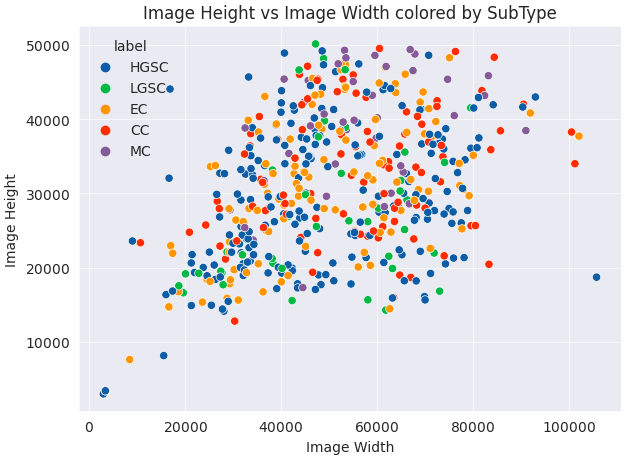

In [5]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=train.image_width,y=train.image_height,hue=train.label)
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Image Height vs Image Width colored by SubType');

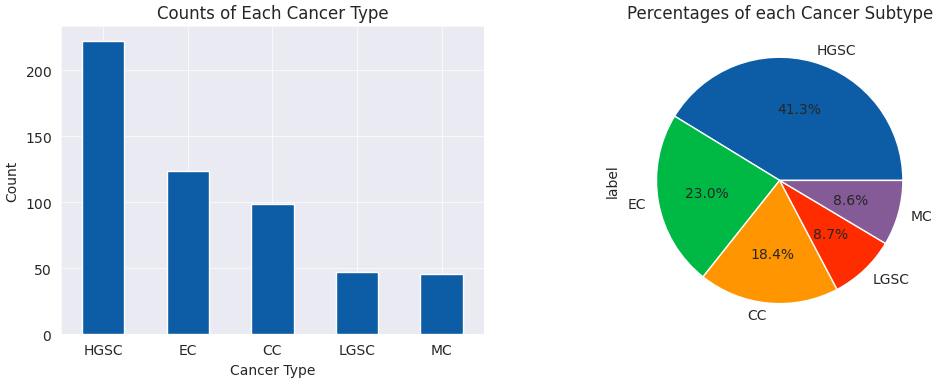

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train['label'].value_counts().plot(kind='bar', xlabel='Cancer Type', ylabel='Count', rot=0)
plt.title('Counts of Each Cancer Type')
plt.subplot(1,2,2)
train['label'].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label")
plt.title('Percentages of each Cancer Subtype');

## Feature Engineering

In [7]:
use_thumbs = False

def set_train_path(n):
    
    if use_thumbs:
        pth = f'{train_thumb_dir}{n}_thumbnail.png'
        if path.exists(pth):
          return Path(f'{train_thumb_dir}{n}_thumbnail.png')
        else:
            return Path(f'{train_dir}{n}.png')
    else:
        return Path(f'{train_dir}{n}.png')

train['train_path'] = train.image_id.apply(lambda x: set_train_path(x))
train.head()

,image_id,label,image_width,image_height,is_tma,train_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_images/4.png
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_images/66.png
2,91,HGSC,3388,3388,True,/kaggle/input/UBC-OCEAN/train_images/91.png
3,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_images/281.png
4,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_images/286.png


# Create Processed Data

In [8]:
# create write dir
write_dir = '/kaggle/working/new_train'
if not os.path.exists(write_dir):
    os.mkdir(write_dir)

## View First Few images

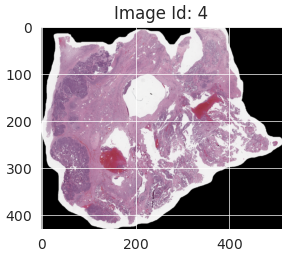

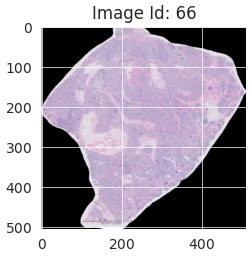

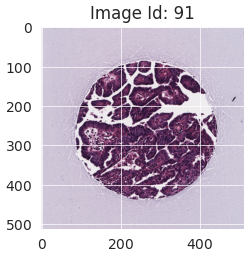

CPU times: user 1min 42s, sys: 4.08 s, total: 1min 47s
Wall time: 1min 53s


In [9]:
%%time

def view_file(row_num=0):

    file = train.train_path[row_num]
    file_id = train.image_id[row_num]
    im = pyvips.Image.thumbnail(file,512)
    plt.imshow(im)
    plt.title(f'Image Id: {file_id}')
    plt.show()

for i in range(3):
    view_file(i)
    
    
# order in df: 4, 66,91(tma),281 will be clipped in rows, same with 286


# Get Random Tile
* Get a bad crop error when cropping to center of img_id 281 (and others)
    * look into this
    * Possibly a mask variable that it sees(?)

In [10]:
def get_random_tile(image, tile_size=512):
    
    half_tile = int(tile_size/2)
    
    # get width and height
    h, w = image.height, image.width

   # Reduce TMA files
    if image.width in [2964,3388]:
        image = image.affine((.5, 0, 0, .5))  
        h, w = image.height, image.width
 
    quality = 0.0
    thresh = 0.98
    count = 0
    failed = 0
    
    # repeat until quality is higher than the threshold
    while quality < thresh:
        
        # get two random values
        top = np.random.randint(0,h-tile_size)
        left = np.random.randint(0,w-tile_size)

        try: 
            # not sure yet which is better: Image.crop, or region.fetch
            # im_out = im_in.crop(top,left,tile_size,tile_size)  # crop original image
            region = pyvips.Region.new(image)
            im_data = region.fetch(top,left,tile_size,tile_size)
            np_data = np.ndarray(buffer=im_data, dtype=np.uint8, shape=[tile_size, tile_size, 3])
            im_out = pyvips.Image.new_from_array(np_data)
            num_gt_0 = ((im_out > 0).avg() * im_out.width * im_out.height * im_out.bands) / 255
            quality = num_gt_0/(3*tile_size**2)  # this is the perecentage of not black pixels
            
        except:
            quality = 0.0
            count +=1 
            
            # if time out, just return an empty image
            if count > 50:  
                print('Timed out, failed image')
                arr = np.zeros((tile_size,tile_size,3))
                im_out = pyvips.Image.new_from_array(arr)
                failed +=1
                break
        
        #print(f'quality: {quality}')

    return im_out


## Create 5 Random tiles from Random location of each image
* test will be about 4x in time

In [ ]:
%%time

num_tiles = 20
tile_size = 512
tile_half = int(tile_size/2)
times = []
#not_proc = []

global_start = datetime.now()

for idx in tqdm(range(len(train))):
    
    start = datetime.now()
    file = train.train_path.iloc[idx]
    label = train.label.iloc[idx]          
    label_path = Path(write_dir,label)

    if not label_path.exists():
        os.mkdir(label_path)
                 
    # load file
    fname = file.name
    im = pyvips.Image.new_from_file(file)
            

    # run processing function
    print(f'Processing {fname}, h,w, = {im.height},{im.width}')
                
    for i in range(num_tiles):
        start = datetime.now()
        im_out = get_random_tile(im,tile_size)
        write_fname = str(label_path) + '/' + fname[0:-4] + '_' + str(i) + '.png'
        im_out.write_to_file(write_fname)
        end = datetime.now()
        elapsed = end - start
        times.append([fname,str(elapsed)])
        print(f'Total Time: {elapsed}')

global_end = datetime.now()
full_elapsed = global_end - global_start
print('Whole set elapsed time = {full_elapsed}')

## Look at Failed Images

In [ ]:
# print(f'Number failed: {len(failed_ids)}')
# print(failed_ids)

# 162 out of 538 failed
# failed indicies
# [281, 706, 1252, 1295, 1660, 1666, 1943, 2391, 2706, 2906, 3055, 3098, 3264, 3672, 3881, 5251, 5264, 5307, 5852, 5992, 6175, 6843, 7955, 8130, 8279, 8985, 9697, 10548, 11263, 11431, 11559, 12222, 12442, 14039, 14051, 14127, 14312, 14542, 15221, 15231, 15293, 15470, 15912, 16042, 16325, 17416, 17738, 18014, 18196, 18896, 18914, 19157, 19512, 20670, 20858, 21232, 21260, 22290, 22425, 22654, 22924, 24023, 24759, 25561, 26190, 26603, 26644, 27739, 27851, 27950, 28121, 28519, 28562, 29331, 29904, 29915, 30508, 30515, 30539, 30738, 30792, 30868, 31333, 31473, 32035, 32596, 32636, 35592, 35652, 35953, 36008, 36063, 36513, 38041, 38097, 38118, 38585, 38687, 38849, 38959, 39144, 39208, 39297, 39365, 40129, 40503, 41361, 42296, 43280, 43875, 43998, 44232, 44700, 44804, 44962, 44976, 45104, 45254, 45578, 45725, 45990, 46543, 46736, 46793, 47984, 48502, 48506, 48861, 48973, 50048, 50246, 50712, 51032, 51832, 52259, 52375, 52420, 52461, 52612, 53059, 54473, 54506, 54825, 54990, 55281, 56500, 56843, 56947, 57100, 59760, 59900, 60685, 60928, 61033, 61100, 61689, 63367, 63429, 63897, 64188, 64824, 65300]


In [ ]:
# failed_id_df = pd.Series(failed_ids)
# failed_id_df.head()

# failed_id_df.to_csv('failed_indices_center_256.csv')

## Processing Times

In [ ]:
times_df = pd.DataFrame(times,columns=['Image_id','proc_time'])
times_df.head()

In [ ]:
times_df.to_csv('proc_time_20_random_512_tiles_TMA_reduce.csv')

## zip directory

In [ ]:
!zip -r -q random_512px_20_tiles_tma_reduced /kaggle/working/new_train